# Compare amount of generation capacity for different scenarios

In [1]:
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

### Load data

REZ generation

In [5]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [6]:
# Tidy column names
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [8]:
_gen.columns

Index(['Solar_renewable_potential_(MW)', 'Wind_renewable_potential_(MW)',
       'Existing_solar', 'Progressive_solar_2029030',
       'Progressive_solar_2039040', 'Progressive_solar_2049050',
       'Step_change_solar_2029030', 'Step_change_solar_2039040',
       'Step_change_solar_2049050', 'Green_energy_solar_2029-30',
       'Green_energy_solar_2039-40', 'Green_energy_solar_2049-50',
       'Existing_wind', 'Progressive_wind_2029030', 'Progressive_wind_2039040',
       'Progressive_wind_2049050', 'Step_change_wind_2029030',
       'Step_change_wind_2039040', 'Step_change_wind_2049050',
       'Green_energy_wind_2029-30', 'Green_energy_wind_2039-40',
       'Green_energy_wind_2049-50'],
      dtype='object')

In [9]:
gen = _gen[[
    "Existing_solar", "Step_change_solar_2029030", "Step_change_solar_2039040", "Step_change_solar_2049050",
    "Existing_wind", "Step_change_wind_2029030", "Step_change_wind_2039040", "Step_change_wind_2049050"]]

In [10]:
gen.head()

,Existing_solar,Step_change_solar_2029030,Step_change_solar_2039040,Step_change_solar_2049050,Existing_wind,Step_change_wind_2029030,Step_change_wind_2039040,Step_change_wind_2049050
REZ,,,,,,,,
N1,166,0,50,100,0,0,0,0
N2,855,0,2400,5400,442,3000,7400,7400
N3,1497,1450,4400,6850,673,5450,5450,7800
N4,53,150,150,400,198,100,100,150
N5,1122,1150,1150,2250,0,600,600,1000


Sites outside REZs - easiest to pull this from mask we created

In [11]:
solar_outside = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_outside_REZ_mask_era5.nc",
)

In [26]:
# Check that we can add REZ current to sites outside REZs
# Total generation for sites
s = solar_outside.solar_site.sel(region="NSW")
print("Site capacity: ", s.sum().values)

# Generation for REZs (currently)
r = gen.loc[[i for i in gen.index if i[0] == "N"]]["Existing_solar"]
print("REZ capacity: ", r.sum())

# Compare with OpenNEM current and committed (5,292 as of 05/12/2024)
print("OpenNEM: 5292, compared to here: ", s.sum().values + r.sum())

Site capacity:  1084.312
REZ capacity:  4149
OpenNEM: 5292, compared to here:  5233.312


In [27]:
wind_outside = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_outside_REZ_mask_era5.nc",
)

##### Sum REZ generation by each state

In [29]:
rez_state_totals = gen.groupby(gen.index.str[0]).sum()

In [37]:
rez_state_totals.index = ["NSW", "QLD", "SA", "TAS", "VIC"]

In [41]:
rez_state_totals = rez_state_totals.loc[["NSW", "QLD", "VIC", "SA", "TAS"]]

In [42]:
rez_state_totals

,Existing_solar,Step_change_solar_2029030,Step_change_solar_2039040,Step_change_solar_2049050,Existing_wind,Step_change_wind_2029030,Step_change_wind_2039040,Step_change_wind_2049050
NSW,4149,3350,8750,16500,1696,9950,14900,18650
QLD,3189,250,9050,22450,2602,8000,15500,19900
VIC,1696,350,1400,6700,5234,3650,13480,16480
SA,859,0,750,4800,2696,1500,2200,4950
TAS,0,0,0,0,563,1550,2200,3200


##### Sum site generation by state

In [33]:
wind_site_state_totals = wind_outside.wind_site.sum(["lat", "lon"])

In [45]:
wind_site_state_totals

<xarray.DataArray 'wind_site' (region: 5)> Size: 40B
array([974.66,   0.  , 196.6 ,  92.  ,   0.  ])
Coordinates:
  * region   (region) <U3 60B 'NSW' 'QLD' 'VIC' 'SA' 'TAS'
    time     datetime64[ns] 8B ...

In [34]:
solar_site_state_totals = solar_outside.solar_site.sum(["lat", "lon"])

### Plot

In [78]:
from matplotlib.lines import Line2D

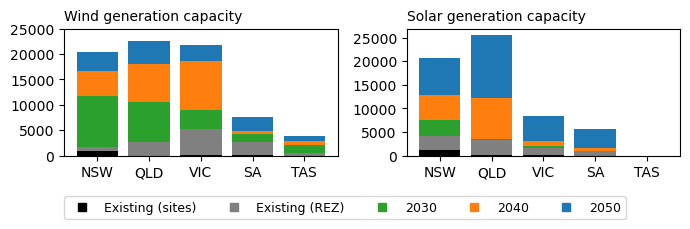

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2))

val1 = wind_site_state_totals
ax[0].bar(wind_site_state_totals.region.values, val1, color="k", zorder=0)

val2 = rez_state_totals["Existing_wind"]
ax[0].bar(wind_site_state_totals.region.values, val2, bottom=val1, color="gray", zorder=0)

val3 = rez_state_totals["Step_change_wind_2029030"]
ax[0].bar(wind_site_state_totals.region.values, val3, bottom=val2, color="tab:green", zorder=2)

val4 = rez_state_totals["Step_change_wind_2039040"]
ax[0].bar(wind_site_state_totals.region.values, val4, bottom=val2, color="tab:orange", zorder=1)

val5 = rez_state_totals["Step_change_wind_2049050"]
ax[0].bar(wind_site_state_totals.region.values, val5, bottom=val2, color="tab:blue", zorder=0)


val1 = list(solar_site_state_totals.values) + [0.]
ax[1].bar(wind_site_state_totals.region.values, val1, color="k", zorder=0)

val2 = rez_state_totals["Existing_solar"]
ax[1].bar(wind_site_state_totals.region.values, val2, bottom=val1, color="gray", zorder=0)

val3 = rez_state_totals["Step_change_solar_2029030"]
ax[1].bar(wind_site_state_totals.region.values, val3, bottom=val2, color="tab:green", zorder=2)

val4 = rez_state_totals["Step_change_solar_2039040"]
ax[1].bar(wind_site_state_totals.region.values, val4, bottom=val2, color="tab:orange", zorder=1)

val5 = rez_state_totals["Step_change_solar_2049050"]
ax[1].bar(wind_site_state_totals.region.values, val5, bottom=val2, color="tab:blue", zorder=0)

ax[0].set_yticks(range(0, 25001, 5000))
ax[1].set_yticks(range(0, 25001, 5000))

ax[0].set_title("Wind generation capacity", loc="left", fontsize=10)
ax[1].set_title("Solar generation capacity", loc="left", fontsize=10)

plt.tight_layout()

# Manual legend   
col1 = Line2D([0], [0], marker='s', linestyle="None", color="k")
col2 = Line2D([0], [0], marker='s', linestyle="None", color="tab:gray")
col3 = Line2D([0], [0], marker='s', linestyle="None", color="tab:green")
col4 = Line2D([0], [0], marker='s', linestyle="None", color="tab:orange")
col5 = Line2D([0], [0], marker='s', linestyle="None", color="tab:blue")

cols = [col1, col2, col3, col4, col5]
labels = ["Existing (sites)", "Existing (REZ)", "2030", "2040", "2050"]
ax[0].legend(
    cols,
    labels,
    loc=(0.0, -0.5),
    ncol=5,
    frameon=True,
    fontsize=9
)